<a href="https://colab.research.google.com/github/JoongseokPark/machine_learning_2023/blob/main/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5_9%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 순환신경망

순차 데이터 : 순서가 의미가 있고, 순서의 변환이 의미를 손상시키는 데이터
- Temporal Sequence : 순서가 중요한
- Time Series : 시간이 중요한

순환 신경망 종류
1. One to One : 기본적인 순환 신경망(RNN)
2. One to Many : 이미지 -> 문장
3. Many to One : 문장 -> 긍정, 부정, 감성평가 (9주차 과정)
4. Many to Many : 문장 -> 문장 , 챗봇, 번역기 등에 사용

Simple RNN 알고리즘
> 출력값 = 함수(tanh(가중치*이전 출력값 + 가중치 * 현재 출력값))
- 이전 출력값 부분(시점)이 길어진다면 미분값이 0이나 무한으로 수렴하기에 긴 출력에는 문제가 있는 모델이다

- 보완 모델 : LSTM, GRU

##자연어 처리
- 자연어 처리 과정
1. 토큰화 : 문장을 띄어쓰기 기준으로 나눔 + 단어 사전 매핑(단어와 숫자 매칭)
2. 불용어 처리 : 온점(.)과 같이 의미 없는 문자
3. 정수 인코딩 : 사전을 바탕으로 문장을 숫자로 변경
4. 패딩 : 인코딩 된 문장의 길이를 동일하게 변경

한국어 감성분석
1. 데이터 불러오기
2. 탐색적 데이터 분석
3. 형태소 분석기 불러오기
4. 데이터 전처리
5. 모델링
6. 평가
7. 저장 모델 불러오기
8. 예측

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #그림 그리는 패키지
import matplotlib.pyplot as plt 
import tensorflow as tf

import warnings 
warnings.filterwarnings(action='ignore')

##데이터 불러오기

In [2]:
# Naver sentiment movie corpus v1.0 데이터 불러오기
train_file = tf.keras.utils.get_file(
    'ratings_train.txt', origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', extract=True)

train = pd.read_csv(train_file, sep='\t')

14628807/14628807 [==============================] - 0s 0us/step


##탐색적 데이터 분석

In [3]:
# 데이터 크기 및 샘플 확인
print("train shape: ", train.shape)
train.head()

train shape:  (150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# 레이블별 개수
cnt = train['label'].value_counts()
print(cnt)
#0 = 부정
#1 = 긍정

0    75173
1    74827
Name: label, dtype: int64


<Axes: xlabel='label', ylabel='count'>

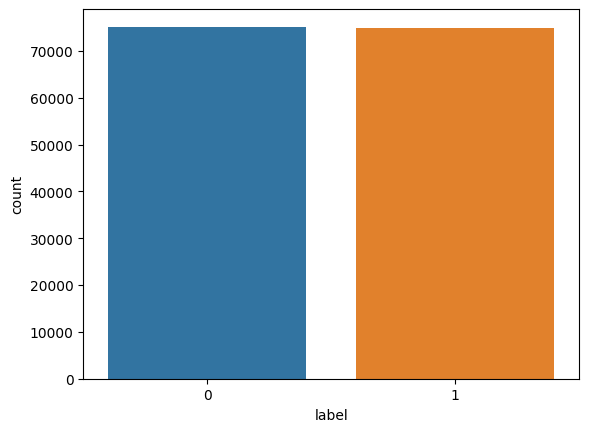

In [5]:
sns.countplot(x='label',data=train)

In [6]:
# 결측치 확인
train.isnull().sum()  

id          0
document    5
label       0
dtype: int64

In [7]:
# 결측치(의견없음)가 특정 label값만 있는지 확인
train[train['document'].isnull()]
#결측치만 출력

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


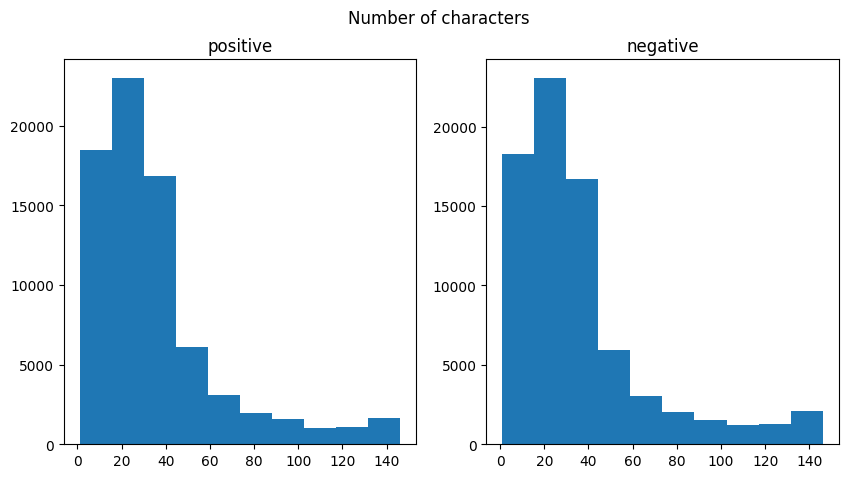

In [8]:
# 레이블 별 텍스트 길이
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len=train[train['label']==1]['document'].str.len() #라벨
ax1.hist(data_len)
ax1.set_title('positive')

data_len=train[train['label']==0]['document'].str.len()
ax2.hist(data_len)
ax2.set_title('negative')
fig.suptitle('Number of characters')
plt.show()

#형태소 분석기 불러오기

In [9]:
# Mecab 형태소 설치
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 9.05 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [10]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [11]:
! bash install_mecab-ko_on_colab_light_220429.sh

Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.7 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-05-08 01:00:10--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-disposition=attachment%3B%20filename%3D%22mecab-0.996-ko-0.9.2.tar.gz%22&response-content-encoding=None&AWSAccessKeyId=

In [13]:
# Kkma, Komoran, Okt, Mecab 형태소
import konlpy
from konlpy.tag import Kkma, Komoran, Okt, Mecab

kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

In [14]:
# 형태소별 샘플
text = "영실아안녕오늘날씨어때?"

def sample_ko_pos(text):
    print(f"==== {text} ====")
    print("kkma:",kkma.pos(text))
    print("komoran:",komoran.pos(text))
    print("okt:",okt.pos(text))
    print("mecab:",mecab.pos(text))
    print("\n")

sample_ko_pos(text)

==== 영실아안녕오늘날씨어때? ====
kkma: [('영', 'MAG'), ('싣', 'VV'), ('아', 'ECD'), ('안녕', 'NNG'), ('오늘날', 'NNG'), ('씨', 'VV'), ('어', 'ECD'), ('때', 'NNG'), ('?', 'SF')]
komoran: [('영', 'NNP'), ('실', 'NNP'), ('아', 'NNP'), ('안녕', 'NNP'), ('오늘날', 'NNP'), ('씨', 'NNB'), ('어떻', 'VA'), ('어', 'EF'), ('?', 'SF')]
okt: [('영', 'Modifier'), ('실아', 'Noun'), ('안녕', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab: [('영실', 'NNG'), ('아', 'IC'), ('안녕', 'IC'), ('오늘', 'MAG'), ('날씨', 'NNG'), ('어때', 'VA+EF'), ('?', 'SF')]




#데이터 전처리

In [15]:
# 텍스트 전처리(영어와 한글만 남기고 삭제)
train['document'] = train['document'].str.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]","")
train['document'].head()

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [16]:
# 결측치 제거
train = train.dropna()
train.shape

(149995, 3)

In [31]:
# 스탑워드와 형태소 분석
def word_tokenization(text):
  stop_words = ["아", "는", "을", "를", '이', '가', '의', '던', '고', '하', '다', '은', '에', '들', '지', '게', '도'] # 한글 불용어

  return [word for word in mecab.morphs(text) if word not in stop_words]

In [32]:
data = train['document'].apply((lambda x: word_tokenization(x)))
data

0                                [더, 빙, 진짜, 짜증, 나, 네요, 목소리]
1            [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
2                                   [너무, 재, 밓었다그래서보는것을추천한다]
3                        [교도소, 이야기, 구먼, 솔직히, 재미, 없, 평점, 조정]
4         [사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 에서, 늙, 어, ...
                                ...                        
149995                               [인간, 문제지, 소, 뭔, 죄, 인가]
149996                                      [평점, 너무, 낮, 아서]
149997                  [이게, 뭐, 요, 한국인, 거들먹거리, 필리핀, 혼혈, 착하]
149998                  [청춘, 영화, 최고봉, 방황, 과, 우울, 했, 날, 자화상]
149999                      [한국, 영화, 최초, 로, 수간, 내용, 담긴, 영화]
Name: document, Length: 149995, dtype: object

In [33]:
# train과 validation 분할

training_size = 120000

# train 분할 : mnist의 train과 test의 역할과 동일
train_sentences = data[:training_size]
valid_sentences = data[training_size:]

# label 분할
train_labels = train['label'][:training_size]
valid_labels = train['label'][training_size:]

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# vocab_size 설정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
print("총 단어 갯수 : ",len(tokenizer.word_index))

# 5회 이상만 vocab_size에 포함
def get_vocab_size(threshold):
  cnt = 0
  for x in tokenizer.word_counts.values():
    if x >= threshold:
      cnt = cnt + 1
  return cnt

vocab_size = get_vocab_size(5) # 5회 이상 출현 단어
print("vocab_size: ", vocab_size)

총 단어 갯수 :  52258
vocab_size:  15562


In [35]:
oov_tok = "" # 사전에 없는 단어
vocab_size = 15000

tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(data)
print(tokenizer.word_index)
print("단어 사전 개수:", len(tokenizer.word_counts))

{'': 1, '영화': 2, '한': 3, '보': 4, '있': 5, '없': 6, '좋': 7, '나': 8, '었': 9, '만': 10, '는데': 11, '너무': 12, '봤': 13, '적': 14, '안': 15, '로': 16, '정말': 17, '음': 18, '으로': 19, '것': 20, '재밌': 21, '네요': 22, '어': 23, '지만': 24, '같': 25, '진짜': 26, '에서': 27, '했': 28, '기': 29, '네': 30, '점': 31, '않': 32, '거': 33, '았': 34, '수': 35, '되': 36, '면': 37, 'ㅋㅋ': 38, '인': 39, '과': 40, '말': 41, '연기': 42, '잘': 43, '최고': 44, '주': 45, '내': 46, '평점': 47, '이런': 48, '와': 49, '어요': 50, '할': 51, '왜': 52, '겠': 53, '해': 54, '스토리': 55, 'ㅋㅋㅋ': 56, '습니다': 57, '듯': 58, '아니': 59, '드라마': 60, '생각': 61, '더': 62, '그': 63, '싶': 64, '사람': 65, '감동': 66, '때': 67, '함': 68, '배우': 69, '본': 70, '까지': 71, '좀': 72, '보다': 73, '뭐': 74, '볼': 75, '알': 76, '만들': 77, '내용': 78, '감독': 79, '라': 80, '재미': 81, '그냥': 82, '시간': 83, '재미있': 84, '지루': 85, '중': 86, '잼': 87, '재미없': 88, '였': 89, '년': 90, '쓰레기': 91, '사랑': 92, '못': 93, '냐': 94, '서': 95, '라고': 96, '니': 97, '면서': 98, '다시': 99, '번': 100, '나오': 101, '야': 102, '작품': 103, '하나': 104, '이거': 105, '줄': 1

In [36]:
# 문자를 숫자로 표현
print(train_sentences[:2])
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
print(train_sequences[:2])

0                        [더, 빙, 진짜, 짜증, 나, 네요, 목소리]
1    [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
Name: document, dtype: object
[[62, 928, 26, 214, 8, 22, 706], [974, 486, 327, 635, 2, 106, 1568, 42, 799, 961, 32, 366]]


In [38]:
# 문장의 최대 길이
max_length = max(len(x) for x in train_sequences)
print("문장 최대 길이:", max_length)

문장 최대 길이: 74


In [39]:
# 문장 길이를 동일하게 맞춘다
trunc_type='post'
padding_type='post'

train_padded = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
valid_padded = pad_sequences(valid_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)

train_labels = np.asarray(train_labels).reshape(-1,1)
valid_labels = np.asarray(valid_labels).reshape(-1,1)

print("샘플:", train_padded[:1])

샘플: [[ 62 928  26 214   8  22 706   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]


#양방향 LSTM  모델



In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

def create_model():
    model = Sequential([
                Embedding(vocab_size, 32),
                Bidirectional(LSTM(32, return_sequences=True)),    
                Dense(32, activation='relu'),
                Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          480000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 498,753
Trainable params: 498,753
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 가장 좋은 loss의 가중치 저장
checkpoint_path = 'best_performed_model.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                monitor='val_loss',
                                                verbose=1)

In [42]:
# 학습조기종료
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# 학습
history = model.fit(train_padded, train_labels, 
                validation_data=(valid_padded, valid_labels), 
                callbacks=[early_stop, checkpoint], batch_size=64, epochs=10, verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.35050, saving model to best_performed_model.ckpt
1875/1875 - 91s - loss: 0.4033 - accuracy: 0.8134 - val_loss: 0.3505 - val_accuracy: 0.8475 - 91s/epoch - 49ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.35050
1875/1875 - 20s - loss: 0.3136 - accuracy: 0.8654 - val_loss: 0.3513 - val_accuracy: 0.8442 - 20s/epoch - 11ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.35050 to 0.33753, saving model to best_performed_model.ckpt
1875/1875 - 19s - loss: 0.2738 - accuracy: 0.8834 - val_loss: 0.3375 - val_accuracy: 0.8553 - 19s/epoch - 10ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.33753
1875/1875 - 18s - loss: 0.2443 - accuracy: 0.8984 - val_loss: 0.3589 - val_accuracy: 0.8483 - 18s/epoch - 10ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.33753
1875/1875 - 17s - loss: 0.2188 - accuracy: 0.9101 - val_loss: 0.3774 - val_accuracy: 0.8484 - 17s/epoch - 9ms/step


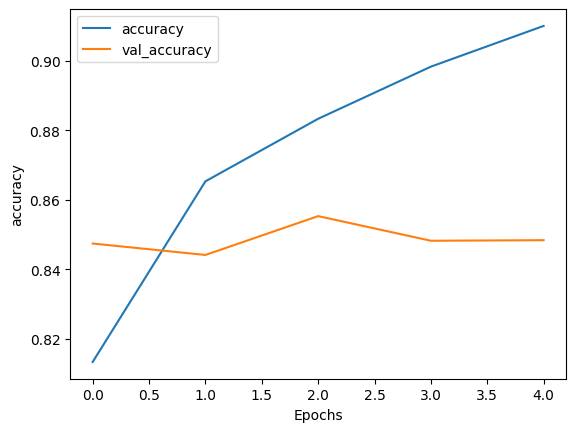

In [43]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
plot_graphs(history, 'accuracy')

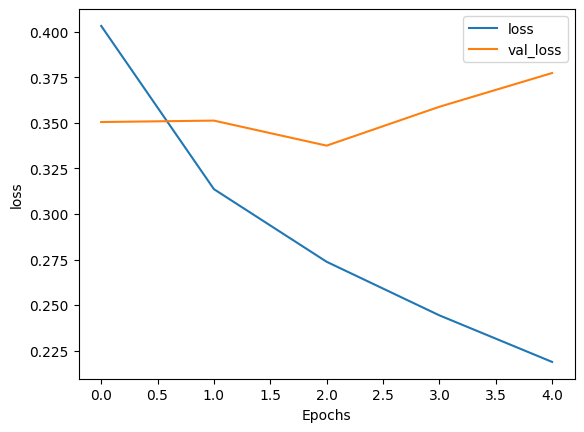

In [44]:
plot_graphs(history, 'loss')

In [45]:
# 테스트 데이터 불러오기
test_file = tf.keras.utils.get_file(
    'ratings_test.txt', origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', extract=True)

test = pd.read_csv(test_file, sep='\t')
test.head()

4893335/4893335 [==============================] - 0s 0us/step


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [48]:
# 데이터 전처리
def preprocessing(df):
  df['document'] = df['document'].str.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]","")
  df = df.dropna()
  test_label = np.asarray(df['label']).reshape(-1,1)
  test_data =  df['document'].apply((lambda x: word_tokenization(x)))
  test_data = tokenizer.texts_to_sequences(test_data)
  test_data = pad_sequences(test_data, truncating=trunc_type, padding=padding_type, maxlen=max_length)
  return test_data, test_label

test_data, test_label = preprocessing(test)
print(model.evaluate(test_data, test_label))

1563/1563 [==============================] - 10s 6ms/step - loss: 0.3855 - accuracy: 0.8455
[0.3854941129684448, 0.8454564809799194]


In [49]:
# 기본 모델 로드 후 평가
model2 = create_model()
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 14s 6ms/step - loss: 0.6932 - accuracy: 0.5004


[0.6931661367416382, 0.500404953956604]

In [50]:
# 저장된 가중치 적용된 모델 로드 후 평가
model2.load_weights(checkpoint_path)
model2.evaluate(test_data, test_label)
#체크포인트에서 불러온 모델의 결과가 더 좋다

1563/1563 [==============================] - 10s 6ms/step - loss: 0.3435 - accuracy: 0.8518


[0.3435143232345581, 0.8518221378326416]